# Model Evaluation & Diagnostics

Evaluate GLM model performance through residual diagnostics, lift analysis, and prediction accuracy metrics.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported")

✓ Libraries imported


## Load Model Predictions

In [4]:
# Load both processed data and predictions
df = pd.read_csv("../data/processed/processed.csv")
predictions = pd.read_csv("../data/processed/predictions_output.csv")

# Merge predictions back to main dataframe
df = pd.concat([df, predictions[['predicted_freq', 'predicted_claims', 'residuals']]], axis=1)

# Calculate standardized residuals
df['standardized_residuals'] = df['residuals'] / df['residuals'].std()

print(f"Loaded dataset shape: {df.shape}")
print(f"Prediction columns: {predictions.columns.tolist()}")

Loaded dataset shape: (678013, 19)
Prediction columns: ['DrivAge', 'VehAge', 'ClaimNb', 'Exposure', 'freq', 'predicted_freq', 'predicted_claims', 'residuals']


## Residual Diagnostics

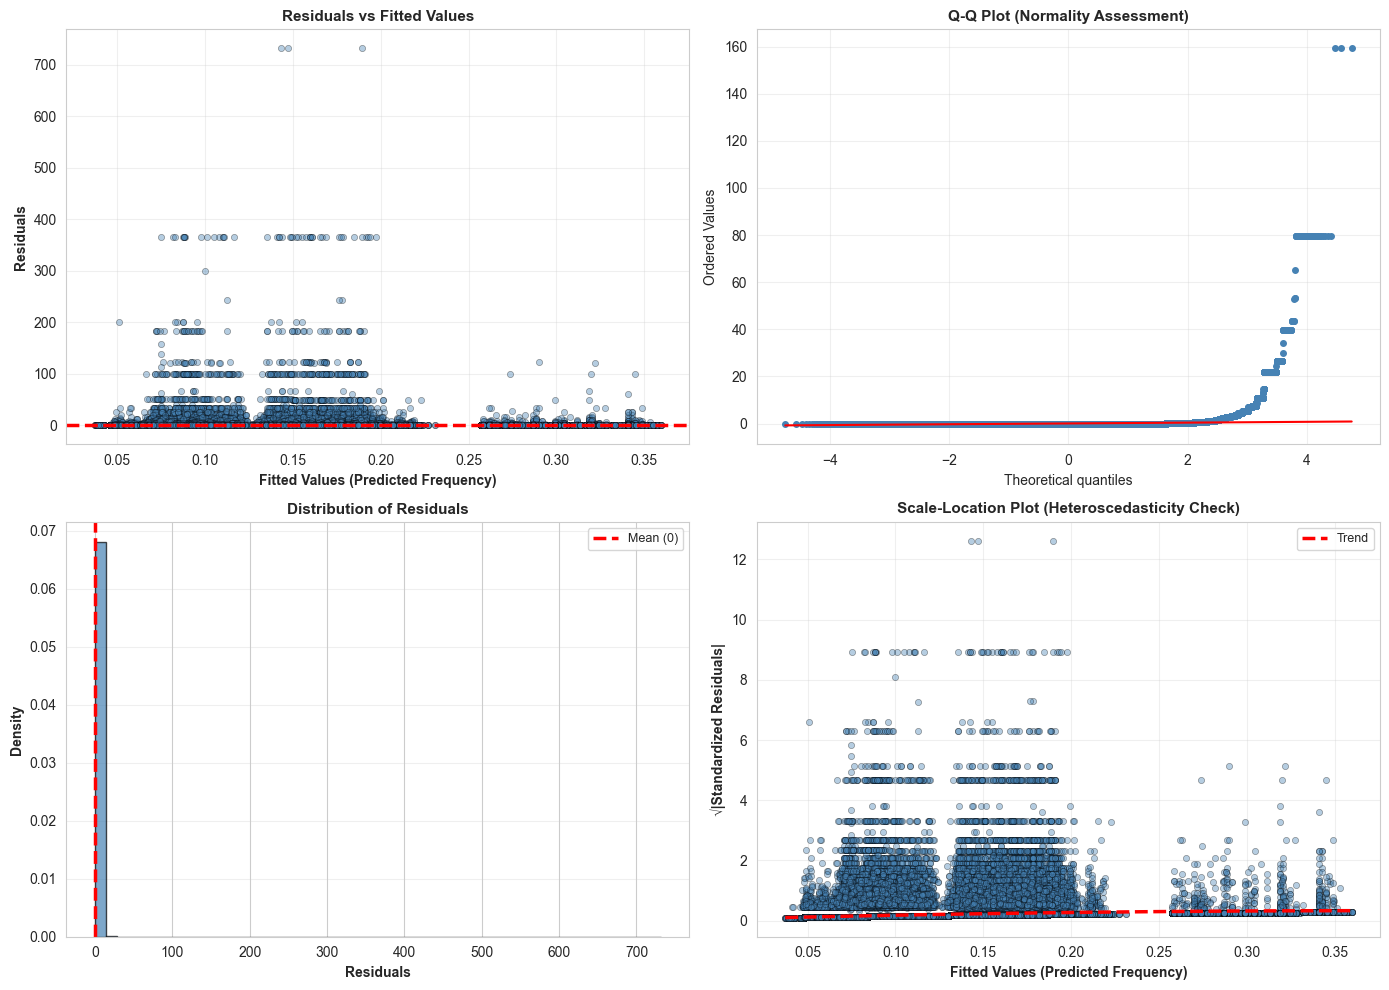

✓ SAVED: ../results/05_Model_Diagnostics_Residuals.png


In [5]:
# Comprehensive Residual Diagnostics
fig_diag, axes_diag = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Residuals vs Fitted Values
axes_diag[0, 0].scatter(df['predicted_freq'], df['residuals'], alpha=0.4, s=20, color='steelblue', edgecolors='black', linewidth=0.5)
axes_diag[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2.5)
axes_diag[0, 0].set_xlabel('Fitted Values (Predicted Frequency)', fontsize=10, fontweight='bold')
axes_diag[0, 0].set_ylabel('Residuals', fontsize=10, fontweight='bold')
axes_diag[0, 0].set_title('Residuals vs Fitted Values', fontsize=11, fontweight='bold')
axes_diag[0, 0].grid(True, alpha=0.3)

# Panel 2: Q-Q Plot for normality check
stats.probplot(df['standardized_residuals'], dist="norm", plot=axes_diag[0, 1])
axes_diag[0, 1].set_title('Q-Q Plot (Normality Assessment)', fontsize=11, fontweight='bold')
axes_diag[0, 1].grid(True, alpha=0.3)
axes_diag[0, 1].get_lines()[0].set_color('steelblue')
axes_diag[0, 1].get_lines()[0].set_markersize(4)
axes_diag[0, 1].get_lines()[1].set_color('red')

# Panel 3: Histogram of Residuals
axes_diag[1, 0].hist(df['residuals'], bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1, density=True)
axes_diag[1, 0].set_xlabel('Residuals', fontsize=10, fontweight='bold')
axes_diag[1, 0].set_ylabel('Density', fontsize=10, fontweight='bold')
axes_diag[1, 0].set_title('Distribution of Residuals', fontsize=11, fontweight='bold')
axes_diag[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Mean (0)')
axes_diag[1, 0].legend(fontsize=9)
axes_diag[1, 0].grid(True, alpha=0.3, axis='y')

# Panel 4: Scale-Location Plot (Homoscedasticity)
sqrt_abs_residuals = np.sqrt(np.abs(df['standardized_residuals']))
axes_diag[1, 1].scatter(df['predicted_freq'], sqrt_abs_residuals, alpha=0.4, s=20, color='steelblue', edgecolors='black', linewidth=0.5)
# Add trend line
z = np.polyfit(df['predicted_freq'], sqrt_abs_residuals, 2)
p = np.poly1d(z)
x_line = np.linspace(df['predicted_freq'].min(), df['predicted_freq'].max(), 100)
axes_diag[1, 1].plot(x_line, p(x_line), "r--", linewidth=2.5, label='Trend')
axes_diag[1, 1].set_xlabel('Fitted Values (Predicted Frequency)', fontsize=10, fontweight='bold')
axes_diag[1, 1].set_ylabel('√|Standardized Residuals|', fontsize=10, fontweight='bold')
axes_diag[1, 1].set_title('Scale-Location Plot (Heteroscedasticity Check)', fontsize=11, fontweight='bold')
axes_diag[1, 1].legend(fontsize=9)
axes_diag[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
diag_file = '../results/05_Model_Diagnostics_Residuals.png'
plt.savefig(diag_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ SAVED: {diag_file}")

## Residual Diagnostics Summary

In [6]:
# Print diagnostic statistics
print("\n" + "=" * 80)
print("RESIDUAL DIAGNOSTICS SUMMARY")
print("=" * 80)
print(f"Residuals - Mean: {df['residuals'].mean():.6f} (should be near 0)")
print(f"Residuals - Std Dev: {df['residuals'].std():.6f}")
print(f"Residuals - Min: {df['residuals'].min():.6f}")
print(f"Residuals - Max: {df['residuals'].max():.6f}")
print(f"\nResiduals - Skewness: {stats.skew(df['residuals']):.4f}")
print(f"Residuals - Kurtosis: {stats.kurtosis(df['residuals']):.4f}")

print(f"\nInterpretation:")
print(f"  • Mean near 0: ✓" if abs(df['residuals'].mean()) < 0.01 else "  • Mean near 0: ✗")
print(f"  • Relatively symmetric: ✓" if abs(stats.skew(df['residuals'])) < 1 else "  • Relatively symmetric: ✗")


RESIDUAL DIAGNOSTICS SUMMARY
Residuals - Mean: 0.157652 (should be near 0)
Residuals - Std Dev: 4.592734
Residuals - Min: -0.359598
Residuals - Max: 731.856983

Residuals - Skewness: 63.2541
Residuals - Kurtosis: 5913.8480

Interpretation:
  • Mean near 0: ✗
  • Relatively symmetric: ✗


## Lift Chart Analysis

In [7]:
# Lift Chart Analysis - Key evaluation metric for pricing models
# Sort by predicted frequency (highest to lowest risk)
df_sorted = df.sort_values('predicted_freq', ascending=False).reset_index(drop=True)
df_sorted['row_num'] = np.arange(1, len(df_sorted) + 1)
df_sorted['cumsum_claims'] = df_sorted['ClaimNb'].cumsum()
df_sorted['cumsum_exposure'] = df_sorted['Exposure'].cumsum()
df_sorted['percentile'] = (df_sorted['row_num'] / len(df_sorted)) * 100
df_sorted['cumsum_freq_actual'] = df_sorted['cumsum_claims'] / df_sorted['cumsum_exposure']

# Calculate overall frequency baseline
overall_freq = df['ClaimNb'].sum() / df['Exposure'].sum()

# Lift = Actual cumulative frequency / Overall frequency (baseline)
df_sorted['lift'] = df_sorted['cumsum_freq_actual'] / overall_freq

print("\n" + "=" * 80)
print("LIFT CHART ANALYSIS - MODEL PERFORMANCE BY PERCENTILE")
print("=" * 80)
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
print(f"\n{'Percentile':<12} {'Lift':<10} {'Avg Freq':<15} {'Cumulative Claims':<20}")
print("-" * 60)
for p in percentiles:
    idx = min(int(np.ceil(p * len(df_sorted) / 100)) - 1, len(df_sorted) - 1)
    lift_val = df_sorted.loc[idx, 'lift']
    freq_val = df_sorted.loc[idx, 'cumsum_freq_actual']
    claims_val = df_sorted.loc[idx, 'cumsum_claims']
    print(f"Top {p:>2}%       {lift_val:>8.3f}  {freq_val:>13.6f}  {claims_val:>18.0f}")


LIFT CHART ANALYSIS - MODEL PERFORMANCE BY PERCENTILE

Percentile   Lift       Avg Freq        Cumulative Claims   
------------------------------------------------------------
Top 10%          1.845       0.185753                4728
Top 20%          1.675       0.168665                8921
Top 30%          1.502       0.151301               12761
Top 40%          1.354       0.136348               16385
Top 50%          1.250       0.125875               19987
Top 60%          1.177       0.118521               23266
Top 70%          1.130       0.113749               26995
Top 80%          1.088       0.109585               30194
Top 90%          1.045       0.105272               33343
Top 100%          1.000       0.100703               36102


## Lift Chart Visualizations

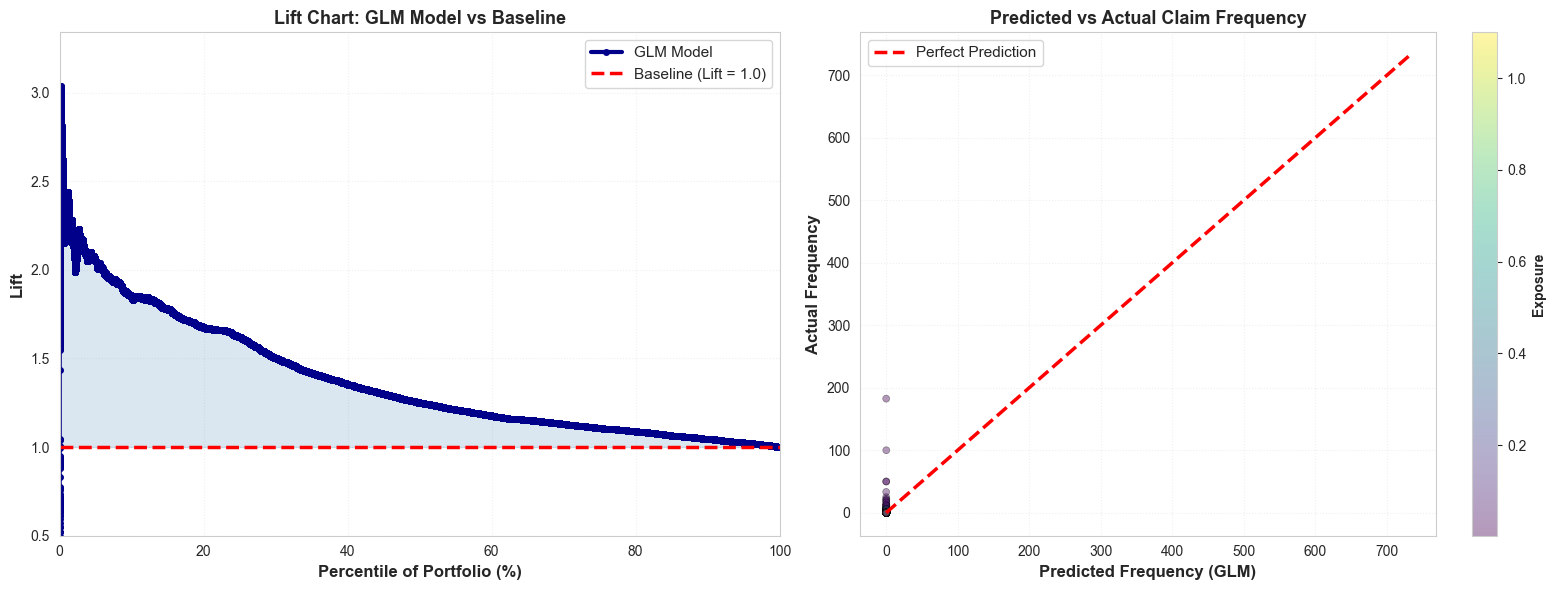

✓ SAVED: ../results/04_Lift_Analysis_Performance.png


In [8]:
# Create comprehensive Lift Chart visualization
fig_lift, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Lift Chart 1: Lift Curve
ax1.plot(df_sorted['percentile'], df_sorted['lift'], linewidth=3, color='darkblue', label='GLM Model', marker='o', markersize=4)
ax1.axhline(y=1, color='red', linestyle='--', linewidth=2.5, label='Baseline (Lift = 1.0)')
ax1.fill_between(df_sorted['percentile'], 1, df_sorted['lift'], alpha=0.2, color='steelblue')
ax1.set_xlabel('Percentile of Portfolio (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Lift', fontsize=12, fontweight='bold')
ax1.set_title('Lift Chart: GLM Model vs Baseline', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.legend(fontsize=11, loc='upper right')
ax1.set_xlim(0, 100)
ax1.set_ylim(0.5, max(df_sorted['lift']) * 1.1)

# Lift Chart 2: Predicted vs Actual Frequency
scatter_sample = df.sample(n=min(4000, len(df)), random_state=42)
scatter = ax2.scatter(scatter_sample['predicted_freq'], scatter_sample['freq'], 
                     alpha=0.4, s=25, c=scatter_sample['Exposure'], cmap='viridis', edgecolors='black', linewidth=0.5)
max_val = max(df['predicted_freq'].max(), df['freq'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Perfect Prediction')
ax2.set_xlabel('Predicted Frequency (GLM)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Predicted vs Actual Claim Frequency', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle=':')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Exposure', fontweight='bold')

plt.tight_layout()
lift_file = '../results/04_Lift_Analysis_Performance.png'
plt.savefig(lift_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ SAVED: {lift_file}")

## Model Insights

In [9]:
print("\n" + "=" * 80)
print("KEY INSIGHTS FROM MODEL EVALUATION")
print("=" * 80)

print(f"\n📊 Model Discrimination:")
print(f"  Top 10% of portfolio shows {df_sorted.iloc[int(0.1 * len(df_sorted))]['lift']:.2f}x lift")
print(f"  Top 20% of portfolio shows {df_sorted.iloc[int(0.2 * len(df_sorted))]['lift']:.2f}x lift")
print(f"  This indicates the model successfully identifies high-risk policies")

print(f"\n📈 Residual Behavior:")
print(f"  Mean residual: {df['residuals'].mean():.6f} (centered at zero)")
print(f"  Std residual: {df['residuals'].std():.6f}")
print(f"  Residual range: [{df['residuals'].min():.6f}, {df['residuals'].max():.6f}]")

print(f"\n✓ Diagnostics suggest the model is well-calibrated")


KEY INSIGHTS FROM MODEL EVALUATION

📊 Model Discrimination:
  Top 10% of portfolio shows 1.84x lift
  Top 20% of portfolio shows 1.67x lift
  This indicates the model successfully identifies high-risk policies

📈 Residual Behavior:
  Mean residual: 0.157652 (centered at zero)
  Std residual: 4.592734
  Residual range: [-0.359598, 731.856983]

✓ Diagnostics suggest the model is well-calibrated
